In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [1]:
!pip install -U tiktoken
!pip install -U shortuuid

In [2]:
!pip install -U transformers==4.45.2
!pip install -U datasets
!pip install -U rouge-score
!pip install -U pymorphy3
!pip install -U peft
!pip install -U evalica

In [4]:
!git clone https://github.com/RefalMachine/llmtf_open

Cloning into 'llmtf_open'...
remote: Enumerating objects: 655, done.
remote: Counting objects: 100% (235/235), done.
remote: Compressing objects: 100% (161/161), done.
remote: Total 655 (delta 161), reused 141 (delta 73), pack-reused 420 (from 1)
Receiving objects: 100% (655/655), 2.32 MiB | 4.82 MiB/s, done.
Resolving deltas: 100% (446/446), done.


In [4]:
%cd llmtf_open
!ls

/content/llmtf_open
conversation_configs	  README.md
cur_battles.json	  requirements.txt
Dockerfile		  run_evaluate_multinode_multigpu.py
eval_grammar.py		  run_evaluate_multinode_multigpu.sh
evaluate_model.py	  run_evaluate_singlenode_multigpu.sh
examples		  run_llm_as_a_judge.py
gigachat_output		  task_RuadaptQwen_32B
gpt_mini_output		  task_RuadaptQwen_7B
llama3-70b		  task_tlite
llm_as_a_judge_baselines  task_tpro
llmtf			  task_vikhr12b
previous_battles.json	  task_yagpt5lite
qwen_output		  todo.txt


In [5]:
import os
import subprocess
import codecs
import json
import tiktoken
import shortuuid
import time

In [6]:
# from llmtf.tasks.llm_as_a_judge import LLMAsJudge
from llmtf.evaluator import Evaluator
from llmtf.model import ApiVLLMModel

In [7]:
from llmtf.base import Task, LLM
from typing import List, Dict, Tuple
import copy
import pandas as pd
import numpy as np
from tqdm import tqdm
from evalica import bradley_terry, Winner, pairwise_frame
from functools import partial
from scipy.special import expit
from scipy.optimize import minimize
from math import log
from random import randint
import re

tqdm.pandas()

In [9]:
STYLE_CONTROL_ELEMENTS = [
    "len_answer",
    "header_count",
    "list_count",
    "bold_count",
    "code_blocks_count"
]

DIFF_MASK = np.array([1.0, -1.0], dtype=np.float64)

def count_style_elements(markdown_text):
    def remove_pattern(answer, pattern):
        blocks = pattern.findall(answer)
        for block in blocks:
            answer = answer.replace(block, "")
        return answer

    len_answer = len(markdown_text)
    code_count = len(re.findall(r"```[^`]+```", markdown_text))
    code_pattern = re.compile("```([^`]+)```")
    markdown_text = remove_pattern(markdown_text, code_pattern)
    markdown_text = markdown_text.replace("```", "")

    mono_count = len(re.findall(r"`[^`]+`", markdown_text))
    mono_pattern = re.compile("`([^`]+)`")
    markdown_text = remove_pattern(markdown_text, mono_pattern)
    counters = {
        f"len_answer": len_answer,
        f"header_count": {
            "h1": len(re.findall(r"^#{1}\s", markdown_text, re.MULTILINE)),
            "h2": len(re.findall(r"^#{2}\s", markdown_text, re.MULTILINE)),
            "h3": len(re.findall(r"^#{3}\s", markdown_text, re.MULTILINE)),
            "h4": len(re.findall(r"^#{4}\s", markdown_text, re.MULTILINE)),
            "h5": len(re.findall(r"^#{5}\s", markdown_text, re.MULTILINE)),
            "h6": len(re.findall(r"^#{6}\s", markdown_text, re.MULTILINE)),
        },
        f"list_count": {
            "ordered": len(re.findall(r"^\s*\d+\.\s", markdown_text, re.MULTILINE)),
            "unordered": len(re.findall(r"^\s*[-*+]\s", markdown_text, re.MULTILINE)),
        },
        f"bold_count": {
            "**": len(re.findall(r"\*\*[^*\n]+\*\*", markdown_text)),
            "__": len(re.findall(r"__[^_\n]+__", markdown_text)),
        },
        f"code_blocks_count": {
            "`": mono_count,
            "```": code_count,
        },
    }
    return counters


def extract_style_feature(x, feature):
    val = x[feature]
    if isinstance(val, int):
        return val
    else:
        return sum(val.values())


def get_element_counts(text):
    style_elements = count_style_elements(text)
    el_counts = []
    for feature in style_elements:
        el_counts.append(extract_style_feature(style_elements, feature))
    return el_counts


def calculate_style(
    model_a: pd.Series,
    model_b: pd.Series,
    style_elements: list[str]=STYLE_CONTROL_ELEMENTS
):
    n_features = len(style_elements)
    n_battles = model_a.shape[0]
    style_matrix = np.zeros(shape=(2*n_features, n_battles))
    for idx, element in enumerate(style_elements):
        style_matrix[idx, :] = np.array([el[idx] for el in model_a])
    for idx, element in enumerate(style_elements):
        style_matrix[n_features + idx, :] = np.array([el[idx] for el in model_b])
    style_diff = (style_matrix[:n_features] - style_matrix[n_features]).astype(float)
    style_sum = (style_matrix[:n_features] + style_matrix[n_features]).astype(float)

    style_diff /= style_sum

    style_mean = np.mean(style_diff, axis=1)
    style_std = np.std(style_diff, axis=1)
    features = ((style_diff - style_mean[:, np.newaxis]) / style_std[:, np.newaxis]).T

    return features


def get_matchups_models(model_a: pd.Series, model_b: pd.Series):
    n_rows = len(model_a)
    assert len(model_b) == n_rows
    model_indices, models = pd.factorize(pd.concat([model_a, model_b]))
    matchups = np.column_stack([model_indices[:n_rows], model_indices[n_rows:]])
    return matchups, models.to_list()


def contextual_bt_loss_and_grad(
    params,
    n_competitors,
    matchups,
    features,
    outcomes,
    alpha=1.0,
    reg=1.0,
    half_reg=0.5,
):
    reg_loss = half_reg * np.inner(params, params)

    ratings = params[:n_competitors]
    feature_params = params[n_competitors:]

    matchup_ratings = ratings[matchups]

    bt_logits = alpha * (matchup_ratings[:, 0] - matchup_ratings[:, 1])
    context_logits = np.dot(features, feature_params)
    probs = expit(bt_logits + context_logits)
    loss = (
        -((np.log(probs) * outcomes + np.log(1.0 - probs) * (1.0 - outcomes))).sum()
        + reg_loss
    )

    error = outcomes - probs
    grad = reg * params
    matchups_grads = -alpha * error
    np.add.at(
        grad[:n_competitors], matchups[:, [0, 1]], matchups_grads[:, None] * DIFF_MASK
    )
    # print('N_COMPETITORS:', grad[n_competitors:], type(grad[n_competitors:]))
    # tmp = np.dot(features.T, error)
    # print('ПРОИЗВЕДЕНИЕ:', tmp, type(tmp))
    grad[n_competitors:] -= np.dot(features.T, error)

    return loss, grad, expit(context_logits)


def fit_contextual_bt(
    matchups,
    features,
    outcomes,
    models,
    idxs=None,
    alpha=log(10.0),
    reg=0.5,
    tol=1e-6,
):
    n_features = features.shape[1]
    n_models = len(models)
    initial_params = np.zeros(n_models + n_features, dtype=np.float64)
    half_reg = reg / 2.0

    if idxs is not None:
        matchups, features, outcomes = matchups[idxs], features[idxs], outcomes[idxs]

    result = minimize(
        fun=contextual_bt_loss_and_grad,
        x0=initial_params,
        args=(n_models, matchups, features, outcomes, alpha, reg, half_reg),
        jac=True,
        method="L-BFGS-B",
        options={"disp": False, "maxiter": 100, "gtol": tol},
    )
    loss, grad, context_logits = contextual_bt_loss_and_grad(result["x"], n_models, matchups, features, outcomes, alpha, reg, half_reg)
    return result["x"], loss, grad, context_logits


def compute_style_control(
    df: pd.DataFrame,
    alpha=log(10.0), reg=0.5, tol=1e-6
):
    features = calculate_style(df.model_a_style, df.model_b_style)
    matchups, models = get_matchups_models(df.model_a, df.model_b)
    outcomes = df.winner.values
    params, loss, grad, context_logits = fit_contextual_bt(
        matchups,
        features,
        outcomes,
        models=models,
        alpha=alpha,
        reg=reg,
        tol=tol,
    )
    ratings = params[: len(models)]
    weigths = params[len(models):]
    return ratings, models, weigths, loss, grad, context_logits

In [20]:
def read_json(file_name):
    with open(file_name, encoding="utf-8") as r:
        return json.load(r)


def swap(data, key1, key2):
    tmp = data[key1]
    data[key1] = data[key2]
    data[key2] = tmp


class LLMAsJudge(Task):
    def __init__(self, model_outputs: Dict, references_outputs: List[Dict], custom_instruction=None, style_control=True, pen_only_model=False, **kwargs):
        super().__init__(**kwargs)
        self.model_outputs = model_outputs
        '''
        model_outputs = {
            'model_name': <name> -- имя `главной` модели
            'path': <path> -- путь до ответов данной модели
        }
        '''
        self.references_outputs = references_outputs
        '''
        reference_outputs = [dict, dict, ..., dict], всего с первой моделью сравниваются m=len(reference_outputs) моделей
        reference_outputs[i] = {
            'model_name': <name_i_model> -- имя сравниваемой модели
            'path': <path_i_model> -- путь до ответов данной модели
        }
        '''
        self.custom_instruction = custom_instruction
        self.method = 'calculate_tokens_proba'
        self.style_control = style_control
        self.pen_only_model = pen_only_model
        self._max_new_tokens = 1

    @property
    def choices(self) -> List:
        return ["m", "M"]

    @classmethod
    def name(cls):
        return 'llm_as_judge'

    def _calculate_score(self, df, model_name):
        # taken from https://github.com/VikhrModels/ru_llm_arena/blob/master/show_result.py
        df['winner'] = df['winner'].map({
                1: Winner.X,
                0: Winner.Y
        })

        result = bradley_terry(
            df['model_a'],
            df['model_b'],
            df['winner'],
            weights=df['answer_style_deltas'],
            tolerance=1e-8
        )

        df = pairwise_frame(result.scores)
        np.fill_diagonal(df.values, np.nan)
        return df.loc[model_name].mean()


    def _confident_score_mean(self, results: Dict) -> Dict:
        '''
        На вход подаются
        results = [
            {
                'p': <model_proba_i>,
                'id': <id_i>,
                'model_name': <model_name_i>,
                'reference_model_name': <reference_model_name_i>,
                'styles': {
                    'model':      [x, x, x, x, x],
                    'reference':  [x, x, x, x, x], # [ len_answer, header_count, list_count, bold_count, code_blocks_count ]
                }
            } for i in range(2*n*m) # на каждый instruction было по 2 sample
        ]
        '''

        try:
            with open('previous_battles.json', 'r', encoding='utf-8') as prev_file:
                previous_battles: List[Dict] = json.load(prev_file)
            if not isinstance(previous_battles, list):
                raise ValueError("Файл должен содержать список словарей!")
            results += previous_battles
            with open('previous_battles.json', 'w', encoding='utf-8') as f:
                f.write('[\n')
                for i, item in enumerate(results):
                    line = json.dumps(item, ensure_ascii=False)
                    if i < len(results) - 1:
                        line += ','
                    f.write(f'  {line}\n')  # 2 пробела для отступа
                f.write(']')
        except FileNotFoundError:
            print("Файл previous_battles.json не найден. Создаём новый.")
            with open('previous_battles.json', 'w', encoding='utf-8') as f:
                f.write('[\n')
                for i, item in enumerate(results):
                    line = json.dumps(item, ensure_ascii=False)
                    if i < len(results) - 1:
                        line += ','
                    f.write(f'  {line}\n')  # 2 пробела для отступа
                f.write(']')
        except json.JSONDecodeError:
            print("Ошибка: Файл содержит некорректный JSON.")
        except Exception as e:
            print(f"Неизвестная ошибка: {e}")
        else:
            print("Данные перезаписаны")
        finally:
            print("Начало регрессии")


        full_hash =  ['|'.join([str(r['id']), r['model_name'], r['reference_model_name']]) for r in results]
        model_hash = ['|'.join([str(r['id']), r['model_name']]) for r in results]
        reference_hash = ['|'.join([str(r['id']), r['reference_model_name']]) for r in results]

        df = pd.DataFrame()
        df['p'] = [r['p'] for r in results]
        df['full_hash'] = full_hash
        df['model_hash'] = model_hash
        df['reference_hash'] = reference_hash

        df['model_name'] = [r['model_name'] for r in results]
        df['reference_model_name'] = [r['reference_model_name'] for r in results]

        df['model_style'] = [np.array(r['styles']['model']) for r in results]
        df['reference_style'] = [np.array(r['styles']['reference']) for r in results]

        data = []
        for _, group in df.groupby('model_hash'):
            for _, subgroup in group.groupby('full_hash'):
                # assert subgroup.shape[0] == 2
                if (subgroup['model_name'] == subgroup['reference_model_name']).all(): # or (subgroup['model_style'].tolist()[0] == subgroup['reference_style'].tolist()[0]).all():
                    continue
                pred = int(subgroup['p'].mean() >= 0.5)

                data.append([subgroup['model_name'].tolist()[0], subgroup['reference_model_name'].tolist()[0], pred, subgroup['model_style'].tolist()[0], subgroup['reference_style'].tolist()[0]])
        new_df = pd.DataFrame(data, columns=['model_a', 'model_b', 'winner', 'model_a_style', 'model_b_style'])

        ratings, models, weigths, loss, grad, context_logits = compute_style_control(new_df)
        # ratings = scale_and_offset(ratings, models, new_df['model_a'][0])

        print('----------------------------------------\nRESULTS:')
        for i in range(len(models)):
            print(f"{ratings[i]} - {models[i]}")
        print('----------------------------------------')

        print('----------------------------------------\nRESULTS:')
        for i in range(len(models)):
            print(f"{str(models[i]):32} | {ratings[i]}")
        print('----------------------------------------')

        print('RATINGS:\n[')
        for x in ratings:
          print(f"  {x},")
        print(']')

        new_df['answer_style_deltas'] = context_logits

        score = self._calculate_score(new_df, new_df['model_a'][0])

        return score


    def aggregation(self) -> Dict:
        return {"score": self._confident_score_mean}


    def evaluate(self, sample, y_pred) -> Dict:
        model_proba = float(y_pred[sample['model_label']])
        model_mask_mapping = lambda x: 'model' if x == sample['model_label'] else 'reference'
        styles = {
            model_mask_mapping('m'): get_element_counts(sample['output_m']),
            model_mask_mapping('M'): get_element_counts(sample['output_M'])
        }
        '''
        styles = {
            'model':      [x, x, x, x, x],
            'reference':  [x, x, x, x, x],
        }, where the elements of the array correspond to:
            [ len_answer, header_count, list_count, bold_count, code_blocks_count ]
        '''
        return {
            "score": {
                'p': model_proba,
                'id': sample['id'],
                'model_name': sample['model_name'],
                'reference_model_name': sample['reference_model_name'],
                'styles': styles
            }
        }


    def load_dataset(
        self,
        model: LLM,
        max_len: int,
        max_sample_per_dataset: int,
        few_shot_count: int
    ) -> Tuple[List[Dict], List[Dict]]:
        self.logger.info(f'Ignoring few_shot_count for {self.name()}')
        assert few_shot_count == 0
        '''
        n=len(model_outputs) -- число вопросов
        m=len(reference_model_outputs) -- число моделей в пайплайне

        model_outputs и reference_outputs[i] заменяется на их ответ из json-файла:
        model_outputs[i] = {
            'id': i
            'instruction' : <instruction_i>
            ...
        }
        reference_outputs = [
            {
                {
                    'id' = i
                    'instruction' : <instruction_i>
                    ...
                } for i in range(n)
            } for j in range(m)
        ]
        '''
        model_name = self.model_outputs['model_name']
        model_outputs_path = self.model_outputs['path']
        model_outputs = read_json(model_outputs_path)[:max_sample_per_dataset]
        for i, o in enumerate(model_outputs):
            o['id'] = i

        samples = []
        messages = []
        for reference_outputs in self.references_outputs:
            reference_model_name =  reference_outputs['model_name']
            reference_outputs_path = reference_outputs['path']
            reference_outputs = read_json(reference_outputs_path)[:max_sample_per_dataset]
            assert len(reference_outputs) == len(model_outputs)
            for i, o in enumerate(reference_outputs):
                assert o['instruction'] == model_outputs[i]['instruction']
                o['id'] = i

            for i in range(len(model_outputs)): # по всем заданиям
                sample_direct = self._create_sample(model_outputs[i], reference_outputs[i], model_name, reference_model_name)
                samples.append({'sample': sample_direct})
                messages.append({'messages': self._prepare_messages(sample_direct, model, max_len)})

                sample_reverse = self._reverse_sample(sample_direct)
                samples.append({'sample': sample_reverse})
                messages.append({'messages': self._prepare_messages(sample_reverse, model, max_len)})

        for m in messages:
            m['tokens_of_interest'] = self.choices
        '''
        samples = [
            {
                'id': model_output['id'],
                'model_name': model_name,
                'reference_model_name': reference_model_name,
                'instruction': model_output['instruction'],
                'output_m': model_output['output'],
                'output_M': reference_output['output'],
                'model_label': 'm'
            },
            {
                'id': model_output['id'],
                'model_name': model_name,
                'reference_model_name': reference_model_name,
                'instruction': model_output['instruction'],
                'output_m': reference_output['output'],
                'output_M': model_output['output'],
                'model_label': 'M'
            } for i in range(n)
        ]
        messages = [
            [
                {'role': 'system', 'content': instruction_system},
                {'role': 'user', 'content': user_content_m_M},
                {'role': 'assistant', 'content': instruction_bot}
                'tokens_of_interest': ['m', 'M']
            ],
            [
                {'role': 'system', 'content': instruction_system},
                {'role': 'user', 'content': user_content_M_m},
                {'role': 'assistant', 'content': instruction_bot}
                'tokens_of_interest': ['m', 'M']
            ]
            for i in range(n)
        ]
        '''
        return messages, samples

    def _create_sample(self, model_output, reference_output, model_name, reference_model_name):
        sample = {
            'id': model_output['id'],
            'model_name': model_name,
            'reference_model_name': reference_model_name,
            'instruction': model_output['instruction'],
            'output_m': model_output['output'],
            'output_M': reference_output['output'],
            'model_label': 'm'
        }
        return sample

    def _reverse_sample(self, sample):
        sample_reverse = copy.deepcopy(sample)
        sample_reverse['model_label'] = 'M'
        swap(sample_reverse, 'output_m', 'output_M')
        return sample_reverse

    def _prepare_messages(self, sample: Dict, model: LLM, max_len: int):
        zero_shot_messages = self.create_messages(copy.deepcopy(sample), with_answer=False)
        zero_shot_messages_len = model.count_tokens_for_prompt(model.apply_model_prompt(zero_shot_messages))
        if zero_shot_messages_len >= max_len:
            self.logger.warning(f'WARNING: sample zero-shot len {zero_shot_messages_len} greater then {max_len}. Will be truncated.')
        return zero_shot_messages

    def create_messages(self, sample: Dict, with_answer=False):
        instruction_system = 'You are a helpful assistant, that ranks models by the quality of their answers.'
        instruction_user = '''I want you to create a leaderboard of different of large language models. To do so, I will give you the instructions (prompts) given to the models, and the responses of two models. Please rank the models based on which responses would be preferred by humans. All inputs and outputs should be python dictionaries.

The main language of the these models is **Russian** and you are required to evaluate not only the overall quality of the answers, but also their grammar and coherence.

**Prompt**:
{
    "instruction": "{instruction}",
}

**Models outputs**:
[
    {
        "model": "m",
        "answer": """{output_m}"""
    },
    {
        "model": "M",
        "answer": """{output_M}"""
    }
]

Now please rank the models by the quality of their answers, so that the model with rank 1 has the best output. Then return a list of the model names and ranks, i.e., produce the following output:
[
    {"rank': 1, "model_name": <model-name-winner>},
    {"rank': 2, "model_name": <model-name-loser>}
]

Please provide the ranking that the majority of humans would give.'''
        instruction_bot = '''[
    {"rank': 1, "model_name": "'''
        user_content = instruction_user.replace('{instruction}', sample['instruction']).replace('{output_m}', sample['output_m']).replace('{output_M}', sample['output_M'])
        messages = [
            {'role': 'system', 'content': instruction_system},
            {'role': 'user', 'content': user_content},
            {'role': 'assistant', 'content': instruction_bot}
        ]
        return messages


In [12]:
os.environ['OPENAI_API_KEY'] = '874c364705747e7ab314ceba89c2029c9a72ab2154664c470eb4ce18c2f0acb0'
references = list(os.listdir('llm_as_a_judge_baselines/ru_arena-hard-v0.1'))
references = [{'model_name': '.'.join(ref.split('.')[:-1]), 'path': os.path.join('llm_as_a_judge_baselines/ru_arena-hard-v0.1', ref)} for ref in references]

api_base = 'http://89.169.128.106:6266'
model = ApiVLLMModel(api_base)
model.from_pretrained('qwen2.5-72b')

model.generation_config.max_new_tokens = 1
model.generation_config.repetition_penalty = 1.0
model.generation_config.do_sample = False
model.generation_config.temperature = 0.0
model.generation_config
model.num_procs = 50

references

INFO: 2025-05-24 15:35:34,628: llmtf.base.apivllmmodel: ATTENTION! Hosting vLLM server must have vllm 0.6.3+
INFO:llmtf.base.apivllmmodel:ATTENTION! Hosting vLLM server must have vllm 0.6.3+


[{'model_name': 'llama3-70b',
  'path': 'llm_as_a_judge_baselines/ru_arena-hard-v0.1/llama3-70b.json'},
 {'model_name': 'vikhr12b',
  'path': 'llm_as_a_judge_baselines/ru_arena-hard-v0.1/vikhr12b.json'},
 {'model_name': 'gpt-4o-mini',
  'path': 'llm_as_a_judge_baselines/ru_arena-hard-v0.1/gpt-4o-mini.json'},
 {'model_name': 'gigachat_max_26.20_uncen',
  'path': 'llm_as_a_judge_baselines/ru_arena-hard-v0.1/gigachat_max_26.20_uncen.json'},
 {'model_name': 'tpro',
  'path': 'llm_as_a_judge_baselines/ru_arena-hard-v0.1/tpro.json'},
 {'model_name': 'Qwen2.5-32B-Instruct',
  'path': 'llm_as_a_judge_baselines/ru_arena-hard-v0.1/Qwen2.5-32B-Instruct.json'},
 {'model_name': 'yagpt5lite',
  'path': 'llm_as_a_judge_baselines/ru_arena-hard-v0.1/yagpt5lite.json'},
 {'model_name': 'RuadaptQwen2.5-32B-Pro-Beta',
  'path': 'llm_as_a_judge_baselines/ru_arena-hard-v0.1/RuadaptQwen2.5-32B-Pro-Beta.json'},
 {'model_name': 'tlite',
  'path': 'llm_as_a_judge_baselines/ru_arena-hard-v0.1/tlite.json'},
 {'mod

In [15]:
references = [
    {'model_name': 'gpt-4-1106-preview',
  'path': 'llm_as_a_judge_baselines/ru_arena-hard-v0.1/gpt-4-1106-preview.json'},
    {'model_name': 'gigachat_max_26.20_uncen',
  'path': 'llm_as_a_judge_baselines/ru_arena-hard-v0.1/gigachat_max_26.20_uncen.json'},
    {'model_name': 'Qwen2.5-32B-Instruct',
  'path': 'llm_as_a_judge_baselines/ru_arena-hard-v0.1/Qwen2.5-32B-Instruct.json'},
    {'model_name': 'gpt-4o-mini',
  'path': 'llm_as_a_judge_baselines/ru_arena-hard-v0.1/gpt-4o-mini.json'},
]
references

[{'model_name': 'gpt-4-1106-preview',
  'path': 'llm_as_a_judge_baselines/ru_arena-hard-v0.1/gpt-4-1106-preview.json'},
 {'model_name': 'gigachat_max_26.20_uncen',
  'path': 'llm_as_a_judge_baselines/ru_arena-hard-v0.1/gigachat_max_26.20_uncen.json'},
 {'model_name': 'Qwen2.5-32B-Instruct',
  'path': 'llm_as_a_judge_baselines/ru_arena-hard-v0.1/Qwen2.5-32B-Instruct.json'},
 {'model_name': 'gpt-4o-mini',
  'path': 'llm_as_a_judge_baselines/ru_arena-hard-v0.1/gpt-4o-mini.json'}]

In [ ]:
task_gpt_1106 = LLMAsJudge(
    model_outputs={
        'model_name': 'gpt-4-1106-preview',
        'path': 'llm_as_a_judge_baselines/ru_arena-hard-v0.1/gpt-4-1106-preview.json'
      },
    references_outputs=references)

evaluator = Evaluator()
evaluator.evaluate_dataset(
    task=task_gpt_1106,
    model=model,
    output_dir='gpt_1106_output',
    max_len=4000,
    few_shot_count=0,
    generation_config=None,
    batch_size=256,
    max_sample_per_dataset=10000000000
)

INFO: 2025-05-23 23:08:36,092: llmtf.base.apivllmmodel: Updated generation_config.eos_token_id: None
INFO:llmtf.base.apivllmmodel:Updated generation_config.eos_token_id: None
INFO: 2025-05-23 23:08:36,094: llmtf.base.apivllmmodel: Updated generation_config.stop_strings: None
INFO:llmtf.base.apivllmmodel:Updated generation_config.stop_strings: None
INFO: 2025-05-23 23:08:36,102: llmtf.base.llm_as_judge: Ignoring few_shot_count for llm_as_judge
INFO:llmtf.base.llm_as_judge:Ignoring few_shot_count for llm_as_judge
INFO: 2025-05-23 23:08:37,414: llmtf.base.llm_as_judge: Loading Dataset: 1.31s
INFO:llmtf.base.llm_as_judge:Loading Dataset: 1.31s
100%|██████████| 16/16 [43:52<00:00, 164.55s/it]
INFO: 2025-05-23 23:52:30,295: llmtf.base.llm_as_judge: Processing Dataset: 2632.87s
INFO:llmtf.base.llm_as_judge:Processing Dataset: 2632.87s
INFO: 2025-05-23 23:52:30,299: llmtf.base.llm_as_judge: Results for llm_as_judge:
INFO:llmtf.base.llm_as_judge:Results for llm_as_judge:


Файл previous_battles.json не найден. Создаём новый.
Начало регрессии


INFO: 2025-05-23 23:52:31,597: llmtf.base.llm_as_judge: {'score': np.float64(0.7841589807755948)}
INFO:llmtf.base.llm_as_judge:{'score': np.float64(0.7841589807755948)}


----------------------------------------
RESULTS:
0.31066379747036155 - gpt-4-1106-preview
-0.25006043140377315 - Qwen2.5-32B-Instruct
0.01915397825375859 - gigachat_max_26.20_uncen
-0.07975734432034574 - gpt-4o-mini
----------------------------------------


In [22]:
task_gigachat = LLMAsJudge(
    model_outputs={
        'model_name': 'gigachat_max_26.20_uncen',
        'path': 'llm_as_a_judge_baselines/ru_arena-hard-v0.1/gigachat_max_26.20_uncen.json'
      },
    references_outputs=references)

evaluator = Evaluator()
evaluator.evaluate_dataset(
    task=task_gigachat,
    model=model,
    output_dir='gigachat_output',
    max_len=4000,
    few_shot_count=0,
    generation_config=None,
    batch_size=256,
    max_sample_per_dataset=10000000000
)

INFO: 2025-05-24 08:22:32,602: llmtf.base.apivllmmodel: Updated generation_config.eos_token_id: None
INFO:llmtf.base.apivllmmodel:Updated generation_config.eos_token_id: None
INFO: 2025-05-24 08:22:32,604: llmtf.base.apivllmmodel: Updated generation_config.stop_strings: None
INFO:llmtf.base.apivllmmodel:Updated generation_config.stop_strings: None
INFO: 2025-05-24 08:22:32,606: llmtf.base.llm_as_judge: Ignoring few_shot_count for llm_as_judge
INFO:llmtf.base.llm_as_judge:Ignoring few_shot_count for llm_as_judge
INFO: 2025-05-24 08:22:32,855: llmtf.base.llm_as_judge: Loading Dataset: 0.25s
INFO:llmtf.base.llm_as_judge:Loading Dataset: 0.25s
100%|██████████| 16/16 [40:07<00:00, 150.49s/it]
INFO: 2025-05-24 09:02:40,718: llmtf.base.llm_as_judge: Processing Dataset: 2407.86s
INFO:llmtf.base.llm_as_judge:Processing Dataset: 2407.86s
INFO: 2025-05-24 09:02:40,721: llmtf.base.llm_as_judge: Results for llm_as_judge:
INFO:llmtf.base.llm_as_judge:Results for llm_as_judge:


Данные перезаписаны
Начало регрессии


INFO: 2025-05-24 09:02:42,897: llmtf.base.llm_as_judge: {'score': np.float64(0.6365625332157553)}
INFO:llmtf.base.llm_as_judge:{'score': np.float64(0.6365625332157553)}


----------------------------------------
RESULTS:
0.10513868316459676 - gigachat_max_26.20_uncen
0.15926906465361526 - gpt-4-1106-preview
-0.21476346798972956 - Qwen2.5-32B-Instruct
-0.04964427982847688 - gpt-4o-mini
----------------------------------------


In [23]:
task_qwen = LLMAsJudge(
    model_outputs={
        'model_name': 'Qwen2.5-32B-Instruct',
        'path': 'llm_as_a_judge_baselines/ru_arena-hard-v0.1/Qwen2.5-32B-Instruct.json'
      },
    references_outputs=references)

evaluator = Evaluator()
evaluator.evaluate_dataset(
    task=task_qwen,
    model=model,
    output_dir='qwen_output',
    max_len=4000,
    few_shot_count=0,
    generation_config=None,
    batch_size=256,
    max_sample_per_dataset=10000000000
)

INFO: 2025-05-24 09:06:37,517: llmtf.base.apivllmmodel: Updated generation_config.eos_token_id: None
INFO:llmtf.base.apivllmmodel:Updated generation_config.eos_token_id: None
INFO: 2025-05-24 09:06:37,519: llmtf.base.apivllmmodel: Updated generation_config.stop_strings: None
INFO:llmtf.base.apivllmmodel:Updated generation_config.stop_strings: None
INFO: 2025-05-24 09:06:37,524: llmtf.base.llm_as_judge: Ignoring few_shot_count for llm_as_judge
INFO:llmtf.base.llm_as_judge:Ignoring few_shot_count for llm_as_judge
INFO: 2025-05-24 09:06:37,674: llmtf.base.llm_as_judge: Loading Dataset: 0.15s
INFO:llmtf.base.llm_as_judge:Loading Dataset: 0.15s
100%|██████████| 16/16 [39:50<00:00, 149.43s/it]
INFO: 2025-05-24 09:46:28,614: llmtf.base.llm_as_judge: Processing Dataset: 2390.94s
INFO:llmtf.base.llm_as_judge:Processing Dataset: 2390.94s
INFO: 2025-05-24 09:46:28,615: llmtf.base.llm_as_judge: Results for llm_as_judge:
INFO:llmtf.base.llm_as_judge:Results for llm_as_judge:


Данные перезаписаны
Начало регрессии


INFO: 2025-05-24 09:46:31,702: llmtf.base.llm_as_judge: {'score': np.float64(0.42548573234306136)}
INFO:llmtf.base.llm_as_judge:{'score': np.float64(0.42548573234306136)}


----------------------------------------
RESULTS:
-0.14321774615131938 - Qwen2.5-32B-Instruct
0.0569009923213684 - gigachat_max_26.20_uncen
0.1038299580233437 - gpt-4-1106-preview
-0.017513204193389045 - gpt-4o-mini
----------------------------------------


In [24]:
task_gpt_mini = LLMAsJudge(
    model_outputs={
        'model_name': 'gpt-4o-mini',
        'path': 'llm_as_a_judge_baselines/ru_arena-hard-v0.1/gpt-4o-mini.json'
      },
    references_outputs=references)

evaluator = Evaluator()
evaluator.evaluate_dataset(
    task=task_gpt_mini,
    model=model,
    output_dir='gpt_mini_output',
    max_len=4000,
    few_shot_count=0,
    generation_config=None,
    batch_size=256,
    max_sample_per_dataset=10000000000
)

INFO: 2025-05-24 09:51:45,497: llmtf.base.apivllmmodel: Updated generation_config.eos_token_id: None
INFO:llmtf.base.apivllmmodel:Updated generation_config.eos_token_id: None
INFO: 2025-05-24 09:51:45,500: llmtf.base.apivllmmodel: Updated generation_config.stop_strings: None
INFO:llmtf.base.apivllmmodel:Updated generation_config.stop_strings: None
INFO: 2025-05-24 09:51:45,502: llmtf.base.llm_as_judge: Ignoring few_shot_count for llm_as_judge
INFO:llmtf.base.llm_as_judge:Ignoring few_shot_count for llm_as_judge
INFO: 2025-05-24 09:51:45,637: llmtf.base.llm_as_judge: Loading Dataset: 0.13s
INFO:llmtf.base.llm_as_judge:Loading Dataset: 0.13s
100%|██████████| 16/16 [38:35<00:00, 144.70s/it]
INFO: 2025-05-24 10:30:20,892: llmtf.base.llm_as_judge: Processing Dataset: 2315.25s
INFO:llmtf.base.llm_as_judge:Processing Dataset: 2315.25s
INFO: 2025-05-24 10:30:20,893: llmtf.base.llm_as_judge: Results for llm_as_judge:
INFO:llmtf.base.llm_as_judge:Results for llm_as_judge:


Данные перезаписаны
Начало регрессии


INFO: 2025-05-24 10:30:25,373: llmtf.base.llm_as_judge: {'score': np.float64(0.3782083095860127)}
INFO:llmtf.base.llm_as_judge:{'score': np.float64(0.3782083095860127)}


----------------------------------------
RESULTS:
-0.16590216787350204 - Qwen2.5-32B-Instruct
0.04160411149820332 - gigachat_max_26.20_uncen
0.09118804883005877 - gpt-4-1106-preview
0.033110007545244236 - gpt-4o-mini
----------------------------------------


In [26]:
task_llama3_70b = LLMAsJudge(
    model_outputs={
        'model_name': 'llama3-70b',
        'path': 'llm_as_a_judge_baselines/ru_arena-hard-v0.1/llama3-70b.json'
      },
    references_outputs=references)

evaluator = Evaluator()
evaluator.evaluate_dataset(
    task=task_llama3_70b,
    model=model,
    output_dir='llama3-70b',
    max_len=4000,
    few_shot_count=0,
    generation_config=None,
    batch_size=256,
    max_sample_per_dataset=10000000000
)

INFO: 2025-05-24 10:40:36,925: llmtf.base.apivllmmodel: Updated generation_config.eos_token_id: None
INFO:llmtf.base.apivllmmodel:Updated generation_config.eos_token_id: None
INFO: 2025-05-24 10:40:36,927: llmtf.base.apivllmmodel: Updated generation_config.stop_strings: None
INFO:llmtf.base.apivllmmodel:Updated generation_config.stop_strings: None
INFO: 2025-05-24 10:40:36,929: llmtf.base.llm_as_judge: Ignoring few_shot_count for llm_as_judge
INFO:llmtf.base.llm_as_judge:Ignoring few_shot_count for llm_as_judge
INFO: 2025-05-24 10:40:37,080: llmtf.base.llm_as_judge: Loading Dataset: 0.15s
INFO:llmtf.base.llm_as_judge:Loading Dataset: 0.15s
100%|██████████| 16/16 [41:21<00:00, 155.09s/it]
INFO: 2025-05-24 11:21:58,558: llmtf.base.llm_as_judge: Processing Dataset: 2481.47s
INFO:llmtf.base.llm_as_judge:Processing Dataset: 2481.47s
INFO: 2025-05-24 11:21:58,562: llmtf.base.llm_as_judge: Results for llm_as_judge:
INFO:llmtf.base.llm_as_judge:Results for llm_as_judge:


Данные перезаписаны
Начало регрессии


INFO: 2025-05-24 11:22:04,693: llmtf.base.llm_as_judge: {'score': np.float64(0.3381370433967317)}
INFO:llmtf.base.llm_as_judge:{'score': np.float64(0.3381370433967317)}


----------------------------------------
RESULTS:
-0.1571130478797735 - Qwen2.5-32B-Instruct
0.034230345763147825 - gigachat_max_26.20_uncen
0.0930590202434048 - gpt-4-1106-preview
0.018299546455687887 - gpt-4o-mini
0.011524135417529514 - llama3-70b
----------------------------------------


In [25]:
!ls llm_as_a_judge_baselines/ru_arena-hard-v0.1

gigachat_max_26.20_uncen.json	  RuadaptQwen2.5-7B-Lite-Beta.json
gpt-4-1106-preview.json		  tlite.json
gpt-4o-mini.json		  tpro.json
llama3-70b.json			  vikhr12b.json
Qwen2.5-32B-Instruct.json	  yagpt5lite.json
RuadaptQwen2.5-32B-Pro-Beta.json


In [27]:
task_RuadaptQwen_7B = LLMAsJudge(
    model_outputs={
        'model_name': 'RuadaptQwen2.5-7B-Lite-Beta',
        'path': 'llm_as_a_judge_baselines/ru_arena-hard-v0.1/RuadaptQwen2.5-7B-Lite-Beta.json'
      },
    references_outputs=references)

evaluator = Evaluator()
evaluator.evaluate_dataset(
    task=task_RuadaptQwen_7B,
    model=model,
    output_dir='task_RuadaptQwen_7B',
    max_len=4000,
    few_shot_count=0,
    generation_config=None,
    batch_size=256,
    max_sample_per_dataset=10000000000
)

INFO: 2025-05-24 11:24:13,515: llmtf.base.apivllmmodel: Updated generation_config.eos_token_id: None
INFO:llmtf.base.apivllmmodel:Updated generation_config.eos_token_id: None
INFO: 2025-05-24 11:24:13,518: llmtf.base.apivllmmodel: Updated generation_config.stop_strings: None
INFO:llmtf.base.apivllmmodel:Updated generation_config.stop_strings: None
INFO: 2025-05-24 11:24:13,520: llmtf.base.llm_as_judge: Ignoring few_shot_count for llm_as_judge
INFO:llmtf.base.llm_as_judge:Ignoring few_shot_count for llm_as_judge
INFO: 2025-05-24 11:24:13,670: llmtf.base.llm_as_judge: Loading Dataset: 0.15s
INFO:llmtf.base.llm_as_judge:Loading Dataset: 0.15s
100%|██████████| 16/16 [39:39<00:00, 148.70s/it]
INFO: 2025-05-24 12:03:52,917: llmtf.base.llm_as_judge: Processing Dataset: 2379.24s
INFO:llmtf.base.llm_as_judge:Processing Dataset: 2379.24s
INFO: 2025-05-24 12:03:52,919: llmtf.base.llm_as_judge: Results for llm_as_judge:
INFO:llmtf.base.llm_as_judge:Results for llm_as_judge:


Данные перезаписаны
Начало регрессии


INFO: 2025-05-24 12:04:01,071: llmtf.base.llm_as_judge: {'score': np.float64(0.3124573143004461)}
INFO:llmtf.base.llm_as_judge:{'score': np.float64(0.3124573143004461)}


----------------------------------------
RESULTS:
-0.20550524938502074 - Qwen2.5-32B-Instruct
0.17372636360749077 - RuadaptQwen2.5-7B-Lite-Beta
0.005886682046937743 - gigachat_max_26.20_uncen
0.04687752023773013 - gpt-4-1106-preview
-0.03154720574315417 - gpt-4o-mini
0.010561889236017504 - llama3-70b
----------------------------------------


In [28]:
task_RuadaptQwen_32B = LLMAsJudge(
    model_outputs={
        'model_name': 'RuadaptQwen2.5-32B-Pro-Beta',
        'path': 'llm_as_a_judge_baselines/ru_arena-hard-v0.1/RuadaptQwen2.5-32B-Pro-Beta.json'
      },
    references_outputs=references)

evaluator = Evaluator()
evaluator.evaluate_dataset(
    task=task_RuadaptQwen_32B,
    model=model,
    output_dir='task_RuadaptQwen_32B',
    max_len=4000,
    few_shot_count=0,
    generation_config=None,
    batch_size=256,
    max_sample_per_dataset=10000000000
)

INFO: 2025-05-24 12:32:31,729: llmtf.base.apivllmmodel: Updated generation_config.eos_token_id: None
INFO:llmtf.base.apivllmmodel:Updated generation_config.eos_token_id: None
INFO: 2025-05-24 12:32:31,731: llmtf.base.apivllmmodel: Updated generation_config.stop_strings: None
INFO:llmtf.base.apivllmmodel:Updated generation_config.stop_strings: None
INFO: 2025-05-24 12:32:31,734: llmtf.base.llm_as_judge: Ignoring few_shot_count for llm_as_judge
INFO:llmtf.base.llm_as_judge:Ignoring few_shot_count for llm_as_judge
INFO: 2025-05-24 12:32:31,881: llmtf.base.llm_as_judge: Loading Dataset: 0.15s
INFO:llmtf.base.llm_as_judge:Loading Dataset: 0.15s
100%|██████████| 16/16 [40:14<00:00, 150.89s/it]
INFO: 2025-05-24 13:12:46,093: llmtf.base.llm_as_judge: Processing Dataset: 2414.21s
INFO:llmtf.base.llm_as_judge:Processing Dataset: 2414.21s
INFO: 2025-05-24 13:12:46,095: llmtf.base.llm_as_judge: Results for llm_as_judge:
INFO:llmtf.base.llm_as_judge:Results for llm_as_judge:


Данные перезаписаны
Начало регрессии


INFO: 2025-05-24 13:12:55,079: llmtf.base.llm_as_judge: {'score': np.float64(0.2877607363280383)}
INFO:llmtf.base.llm_as_judge:{'score': np.float64(0.2877607363280383)}


----------------------------------------
RESULTS:
-0.26105889854931097 - Qwen2.5-32B-Instruct
0.3287569758051988 - RuadaptQwen2.5-32B-Pro-Beta
0.11866372061482446 - RuadaptQwen2.5-7B-Lite-Beta
-0.05548888852844742 - gigachat_max_26.20_uncen
-0.0065732039589161345 - gpt-4-1106-preview
-0.10278011574899457 - gpt-4o-mini
-0.021519589634343906 - llama3-70b
----------------------------------------


In [30]:
task_tlite = LLMAsJudge(
    model_outputs={
        'model_name': 'tlite',
        'path': 'llm_as_a_judge_baselines/ru_arena-hard-v0.1/tlite.json'
      },
    references_outputs=references)

evaluator = Evaluator()
evaluator.evaluate_dataset(
    task=task_tlite,
    model=model,
    output_dir='task_tlite',
    max_len=4000,
    few_shot_count=0,
    generation_config=None,
    batch_size=256,
    max_sample_per_dataset=10000000000
)

INFO: 2025-05-24 13:12:55,910: llmtf.base.apivllmmodel: Updated generation_config.eos_token_id: None
INFO:llmtf.base.apivllmmodel:Updated generation_config.eos_token_id: None
INFO: 2025-05-24 13:12:55,913: llmtf.base.apivllmmodel: Updated generation_config.stop_strings: None
INFO:llmtf.base.apivllmmodel:Updated generation_config.stop_strings: None
INFO: 2025-05-24 13:12:55,917: llmtf.base.llm_as_judge: Ignoring few_shot_count for llm_as_judge
INFO:llmtf.base.llm_as_judge:Ignoring few_shot_count for llm_as_judge
INFO: 2025-05-24 13:12:56,070: llmtf.base.llm_as_judge: Loading Dataset: 0.15s
INFO:llmtf.base.llm_as_judge:Loading Dataset: 0.15s
100%|██████████| 16/16 [39:24<00:00, 147.78s/it]
INFO: 2025-05-24 13:52:20,490: llmtf.base.llm_as_judge: Processing Dataset: 2364.42s
INFO:llmtf.base.llm_as_judge:Processing Dataset: 2364.42s
INFO: 2025-05-24 13:52:20,493: llmtf.base.llm_as_judge: Results for llm_as_judge:
INFO:llmtf.base.llm_as_judge:Results for llm_as_judge:


Данные перезаписаны
Начало регрессии


INFO: 2025-05-24 13:52:31,284: llmtf.base.llm_as_judge: {'score': np.float64(0.28600303833520624)}
INFO:llmtf.base.llm_as_judge:{'score': np.float64(0.28600303833520624)}


----------------------------------------
RESULTS:
-0.2679928547455227 - Qwen2.5-32B-Instruct
0.33493142205415477 - RuadaptQwen2.5-32B-Pro-Beta
0.13085597143204708 - RuadaptQwen2.5-7B-Lite-Beta
-0.0630029403563503 - gigachat_max_26.20_uncen
-0.010033491416192475 - gpt-4-1106-preview
-0.12069874846630867 - gpt-4o-mini
0.003891986965553807 - llama3-70b
-0.00795134546736978 - tlite
----------------------------------------


In [32]:
task_tpro = LLMAsJudge(
    model_outputs={
        'model_name': 'tpro',
        'path': 'llm_as_a_judge_baselines/ru_arena-hard-v0.1/tpro.json'
      },
    references_outputs=references)

evaluator = Evaluator()
evaluator.evaluate_dataset(
    task=task_tpro,
    model=model,
    output_dir='task_tpro',
    max_len=4000,
    few_shot_count=0,
    generation_config=None,
    batch_size=256,
    max_sample_per_dataset=10000000000
)

INFO: 2025-05-24 14:06:53,450: llmtf.base.apivllmmodel: Updated generation_config.eos_token_id: None
INFO:llmtf.base.apivllmmodel:Updated generation_config.eos_token_id: None
INFO: 2025-05-24 14:06:53,453: llmtf.base.apivllmmodel: Updated generation_config.stop_strings: None
INFO:llmtf.base.apivllmmodel:Updated generation_config.stop_strings: None
INFO: 2025-05-24 14:06:53,456: llmtf.base.llm_as_judge: Ignoring few_shot_count for llm_as_judge
INFO:llmtf.base.llm_as_judge:Ignoring few_shot_count for llm_as_judge
INFO: 2025-05-24 14:06:53,602: llmtf.base.llm_as_judge: Loading Dataset: 0.15s
INFO:llmtf.base.llm_as_judge:Loading Dataset: 0.15s
100%|██████████| 16/16 [40:11<00:00, 150.74s/it]
INFO: 2025-05-24 14:47:05,489: llmtf.base.llm_as_judge: Processing Dataset: 2411.88s
INFO:llmtf.base.llm_as_judge:Processing Dataset: 2411.88s
INFO: 2025-05-24 14:47:05,493: llmtf.base.llm_as_judge: Results for llm_as_judge:
INFO:llmtf.base.llm_as_judge:Results for llm_as_judge:


Данные перезаписаны
Начало регрессии


INFO: 2025-05-24 14:47:16,717: llmtf.base.llm_as_judge: {'score': np.float64(0.2647443082075124)}
INFO:llmtf.base.llm_as_judge:{'score': np.float64(0.2647443082075124)}


----------------------------------------
RESULTS:
-0.3184040314211038 - Qwen2.5-32B-Instruct
0.29910779567414325 - RuadaptQwen2.5-32B-Pro-Beta
0.09205273652794731 - RuadaptQwen2.5-7B-Lite-Beta
-0.10496920577485687 - gigachat_max_26.20_uncen
-0.05928236718113471 - gpt-4-1106-preview
-0.17007493794122797 - gpt-4o-mini
-0.04174978702461096 - llama3-70b
-0.050636876042776995 - tlite
0.3539566731836415 - tpro
----------------------------------------


In [33]:
task_vikhr12b = LLMAsJudge(
    model_outputs={
        'model_name': 'vikhr12b',
        'path': 'llm_as_a_judge_baselines/ru_arena-hard-v0.1/vikhr12b.json'
      },
    references_outputs=references)

evaluator = Evaluator()
evaluator.evaluate_dataset(
    task=task_vikhr12b,
    model=model,
    output_dir='task_vikhr12b',
    max_len=4000,
    few_shot_count=0,
    generation_config=None,
    batch_size=256,
    max_sample_per_dataset=10000000000
)

INFO: 2025-05-24 14:49:09,085: llmtf.base.apivllmmodel: Updated generation_config.eos_token_id: None
INFO:llmtf.base.apivllmmodel:Updated generation_config.eos_token_id: None
INFO: 2025-05-24 14:49:09,087: llmtf.base.apivllmmodel: Updated generation_config.stop_strings: None
INFO:llmtf.base.apivllmmodel:Updated generation_config.stop_strings: None
INFO: 2025-05-24 14:49:09,090: llmtf.base.llm_as_judge: Ignoring few_shot_count for llm_as_judge
INFO:llmtf.base.llm_as_judge:Ignoring few_shot_count for llm_as_judge
INFO: 2025-05-24 14:49:09,251: llmtf.base.llm_as_judge: Loading Dataset: 0.16s
INFO:llmtf.base.llm_as_judge:Loading Dataset: 0.16s
100%|██████████| 16/16 [35:12<00:00, 132.04s/it]
INFO: 2025-05-24 15:24:21,913: llmtf.base.llm_as_judge: Processing Dataset: 2112.66s
INFO:llmtf.base.llm_as_judge:Processing Dataset: 2112.66s
INFO: 2025-05-24 15:24:21,921: llmtf.base.llm_as_judge: Results for llm_as_judge:
INFO:llmtf.base.llm_as_judge:Results for llm_as_judge:


Данные перезаписаны
Начало регрессии


INFO: 2025-05-24 15:24:35,611: llmtf.base.llm_as_judge: {'score': np.float64(0.2686657045085505)}
INFO:llmtf.base.llm_as_judge:{'score': np.float64(0.2686657045085505)}


----------------------------------------
RESULTS:
-0.306513559385433 - Qwen2.5-32B-Instruct
0.32704460659277046 - RuadaptQwen2.5-32B-Pro-Beta
0.12287206698704978 - RuadaptQwen2.5-7B-Lite-Beta
-0.09577402850845805 - gigachat_max_26.20_uncen
-0.05026551748038653 - gpt-4-1106-preview
-0.15685400936369923 - gpt-4o-mini
-0.008396245311475018 - llama3-70b
-0.019982712668874456 - tlite
0.38243524661521994 - tpro
-0.19456584747670025 - vikhr12b
----------------------------------------


In [17]:
task_yagpt5lite = LLMAsJudge(
    model_outputs={
        'model_name': 'yagpt5lite',
        'path': 'llm_as_a_judge_baselines/ru_arena-hard-v0.1/yagpt5lite.json'
      },
    references_outputs=references)

evaluator = Evaluator()
evaluator.evaluate_dataset(
    task=task_yagpt5lite,
    model=model,
    output_dir='task_yagpt5lite',
    max_len=4000,
    few_shot_count=0,
    generation_config=None,
    batch_size=256,
    max_sample_per_dataset=10000000000
)

INFO: 2025-05-24 15:40:03,912: llmtf.base.apivllmmodel: Updated generation_config.eos_token_id: None
INFO:llmtf.base.apivllmmodel:Updated generation_config.eos_token_id: None
INFO: 2025-05-24 15:40:03,914: llmtf.base.apivllmmodel: Updated generation_config.stop_strings: None
INFO:llmtf.base.apivllmmodel:Updated generation_config.stop_strings: None
INFO: 2025-05-24 15:40:03,917: llmtf.base.llm_as_judge: Ignoring few_shot_count for llm_as_judge
INFO:llmtf.base.llm_as_judge:Ignoring few_shot_count for llm_as_judge
INFO: 2025-05-24 15:40:04,133: llmtf.base.llm_as_judge: Loading Dataset: 0.22s
INFO:llmtf.base.llm_as_judge:Loading Dataset: 0.22s
100%|██████████| 16/16 [35:45<00:00, 134.11s/it]
INFO: 2025-05-24 16:15:49,833: llmtf.base.llm_as_judge: Processing Dataset: 2145.70s
INFO:llmtf.base.llm_as_judge:Processing Dataset: 2145.70s
INFO: 2025-05-24 16:15:49,835: llmtf.base.llm_as_judge: Results for llm_as_judge:
INFO:llmtf.base.llm_as_judge:Results for llm_as_judge:


Данные перезаписаны
Начало регрессии


INFO: 2025-05-24 16:16:04,015: llmtf.base.llm_as_judge: {'score': np.float64(0.3016033754825107)}
INFO:llmtf.base.llm_as_judge:{'score': np.float64(0.3016033754825107)}


----------------------------------------
RESULTS:
-0.23383102055827582 - Qwen2.5-32B-Instruct
0.35359538645241256 - RuadaptQwen2.5-32B-Pro-Beta
0.14773301222792512 - RuadaptQwen2.5-7B-Lite-Beta
-0.0181956138630955 - gigachat_max_26.20_uncen
0.02130797857957193 - gpt-4-1106-preview
-0.07893573950763996 - gpt-4o-mini
0.015748322193837462 - llama3-70b
0.003470185336141974 - tlite
0.4095182041745977 - tpro
-0.17288707647678586 - vikhr12b
-0.4475236385586701 - yagpt5lite
----------------------------------------
----------------------------------------
RESULTS:
Qwen2.5-32B-Instruct             | -0.23383102055827582
RuadaptQwen2.5-32B-Pro-Beta      | 0.35359538645241256
RuadaptQwen2.5-7B-Lite-Beta      | 0.14773301222792512
gigachat_max_26.20_uncen         | -0.0181956138630955
gpt-4-1106-preview               | 0.02130797857957193
gpt-4o-mini                      | -0.07893573950763996
llama3-70b                       | 0.015748322193837462
tlite                            | 0.0034701853361

In [27]:
final_ratings = np.array([
    -0.23383102055827582,
    0.35359538645241256,
    0.14773301222792512,
    -0.0181956138630955,
    0.02130797857957193,
    -0.07893573950763996,
    0.015748322193837462,
    0.003470185336141974,
    0.4095182041745977,
    -0.17288707647678586,
    -0.4475236385586701,
])
models = [
    'Qwen2.5-32B-Instruct',
    'RuadaptQwen2.5-32B-Pro-Beta',
    'RuadaptQwen2.5-7B-Lite-Beta',
    'gigachat_max_26.20_uncen',
    'gpt-4-1106-preview',
    'gpt-4o-mini',
    'llama3-70b',
    'tlite',
    'tpro',
    'vikhr12b',
    'yagpt5lite',
]

In [28]:
def scale_and_offset(
    ratings,
    models,
    baseline_model=None,
    scale=400,
    init_rating=1000,
    baseline_rating=1114,
):
    """convert ratings from the natural scale to the Elo rating scale with an anchored baseline"""
    scaled_ratings = (ratings * scale) + init_rating
    if baseline_model and baseline_model in models:
        baseline_idx = models.index(baseline_model)
        scaled_ratings += baseline_rating - scaled_ratings[..., [baseline_idx]]
    return scaled_ratings

In [43]:
final_ratings

array([-0.23383102,  0.35359539,  0.14773301, -0.01819561,  0.02130798,
       -0.07893574,  0.01574832,  0.00347019,  0.4095182 , -0.17288708,
       -0.44752364])

In [42]:
scale_and_offset(final_ratings, models)
scaled_ratings = scale_and_offset(final_ratings, models)
scaled_ratings

array([ 906.46759178, 1141.43815458, 1059.09320489,  992.72175445,
       1008.52319143,  968.4257042 , 1006.29932888, 1001.38807413,
       1163.80728167,  930.84516941,  820.99054458])

<ipython-input-41-e57245e9d39c>:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('viridis', len(models))  # 'viridis', 'plasma', 'rainbow' и др.


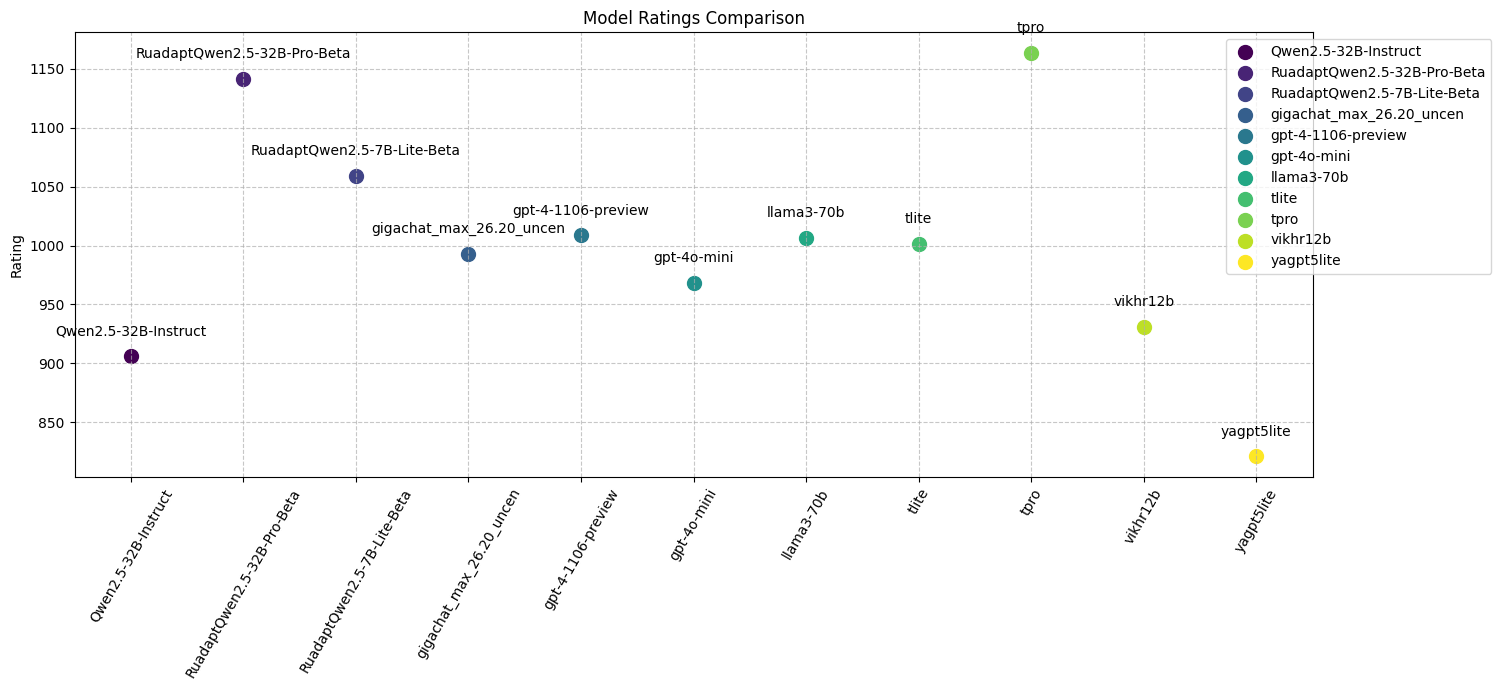

In [41]:
import numpy as np
import matplotlib.pyplot as plt

# Создаём график
plt.figure(figsize=(15, 7))

# Разные цвета для каждой модели (можно использовать готовую палитру)
colors = plt.cm.get_cmap('viridis', len(models))  # 'viridis', 'plasma', 'rainbow' и др.

# Рисуем точки с подписями
for i, (model, rating) in enumerate(zip(models, scaled_ratings)):
    plt.scatter(i, rating, color=colors(i), s=100, label=model)  # s - размер точки
    plt.text(i, rating + 15, model, ha='center', va='bottom')  # Подпись над точкой

# Настройки графика
plt.xticks(range(len(models)), models, rotation=60)  # Подписи по оси X
plt.ylabel("Rating")
plt.title("Model Ratings Comparison")
plt.grid(True, linestyle='--', alpha=0.7)

# Легенда (опционально)
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))

plt.tight_layout()  # Чтобы подписи не вылезали за границы
plt.show()